<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before.

But how to get your own data into PyTorch

One of the ways to do so is via : custom datasets.

## Domain libraries

Depending on what you're worjing on (vision, text, audio, ...) look for existing dataloader in each of those domain libraries to base your implementation on it

**Resources:**
* Book version of the course material for chapter 6 - https://www.learnpytorch.io/04_pytorch_custom_datasets/

* Ground truth version of the notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb


In [2]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
!nvidia-smi

Wed Sep  6 23:38:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Get Data

Our dataset is a subset of the food101 dataset, which starts with 101 classes ours will starte with only 3 classes of food and 10% of images per classes (~ 75 training, 25 testing)

Why are we doing this ?  

When starting out ML Projects, it's important to try thing from a small subset of data to speed up experiments

In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exist, skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak and sushi data")
    f.write(request.content)

  # Unzip
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak sushi data")
    zip_ref.extractall(image_path)



data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak sushi data


 ## 2. Becoming one with the data (data preparation and data exploration)


In [6]:
import os

def walk_through_dir(dir_path):
  """Walks through dir path returning it's contents."""

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path  / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to
1. Get all of the image paths
2. Pick a random image using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with Python PIL
5. Show the image an print metadata

Random image path:data/pizza_steak_sushi/test/sushi/3837522.jpg
Image class:sushi
Image height: 512
Image width: 512


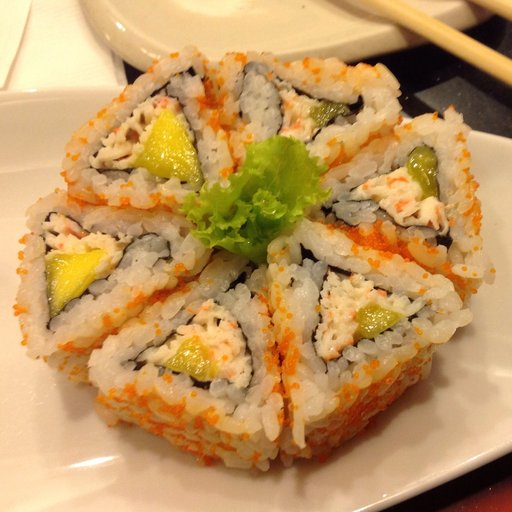

In [9]:
import random
from PIL import Image

# set seed
random.seed(42)

# 1. Get all the images paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name (the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open up the image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path:{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

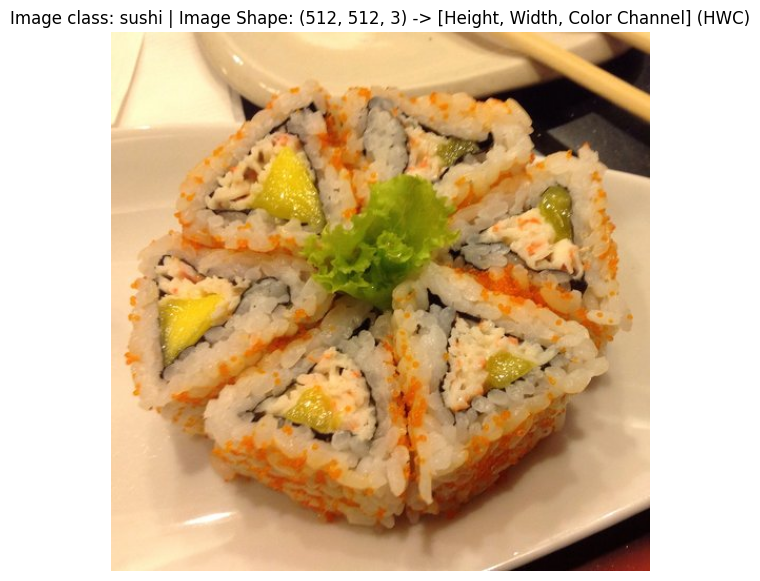

In [10]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image Shape: {img_array.shape} -> [Height, Width, Color Channel] (HWC)")
plt.axis(False)


In [11]:
img_array

array([[[253, 246, 200],
        [254, 247, 201],
        [255, 248, 202],
        ...,
        [252, 214, 133],
        [251, 214, 133],
        [252, 215, 134]],

       [[253, 246, 200],
        [254, 247, 201],
        [255, 248, 202],
        ...,
        [253, 215, 134],
        [254, 216, 135],
        [254, 217, 136]],

       [[253, 246, 200],
        [254, 247, 201],
        [255, 248, 202],
        ...,
        [253, 212, 130],
        [252, 214, 131],
        [253, 215, 132]],

       ...,

       [[253, 220, 175],
        [253, 222, 176],
        [253, 222, 176],
        ...,
        [149,  38,  21],
        [149,  38,  19],
        [150,  39,  20]],

       [[252, 221, 175],
        [252, 221, 175],
        [253, 222, 176],
        ...,
        [150,  37,  19],
        [150,  37,  19],
        [152,  39,  21]],

       [[252, 221, 175],
        [252, 221, 175],
        [251, 223, 176],
        ...,
        [150,  37,  19],
        [150,  37,  19],
        [153,  40,  22]]

## 3. Transforming Data

Before we can use our image data with PyTorch :
1. Turn target data into tensors (in our case, numerical representation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`



In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with `torchvision.transforms`

* Transforms help you get your images ready to be used with a model/perform data augmentation

In [13]:
# Write a transform for image

data_transform = transforms.Compose([
  # Resize ou image to 64X64
  transforms.Resize(size=(64,64)),
  # Flip the images randomly on the Horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn image into a torch.Tensor
  transforms.ToTensor()
])

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

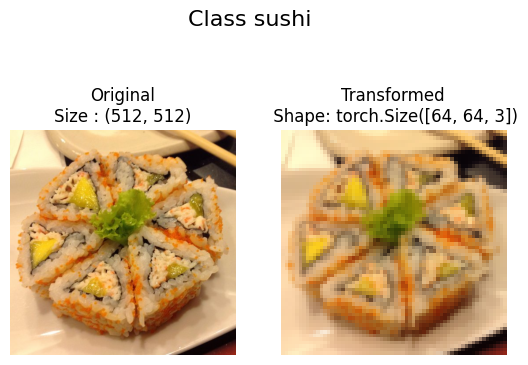

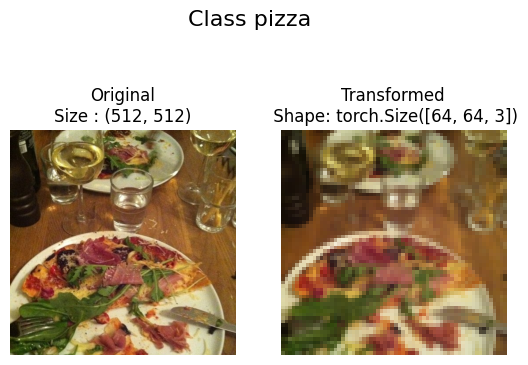

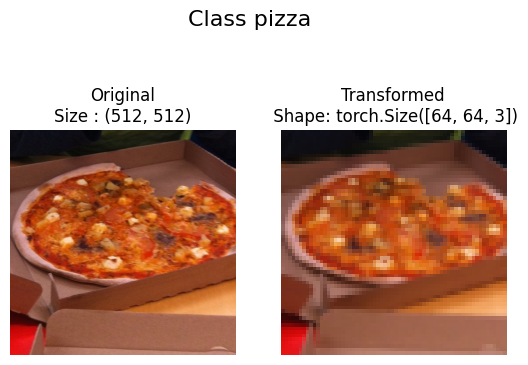

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from paths of images and loads/transforms them
  then plots the original vs transformed version.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize : {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # C, H, W => H,W,C
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\n Shape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classificiation data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder



In [16]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None)    # a transform for the labels

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
#Check the lenght of our dataset
len(train_data), len(test_data)

(225, 75)

In [19]:
# Index on the train data dataset to get a single image and a label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [C,H,W]
Image permute: torch.Size([64, 64, 3]) -> [H, W, C]


Text(0.5, 1.0, 'Pizza')

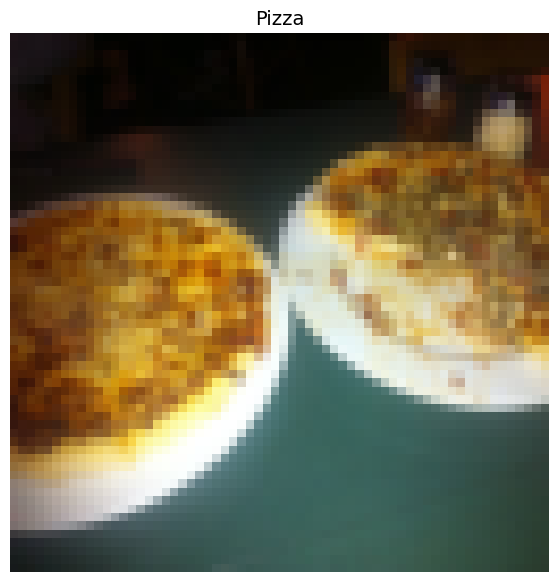

In [20]:
 # Rearrange the order of dimenssions
 img_permute = img.permute(1, 2, 0)

 # Print out different shapes
 print(f"Original shape: {img.shape} -> [C,H,W]")
 print(f"Image permute: {img_permute.shape} -> [H, W, C]")

 # Plot the image
 plt.figure(figsize=(10, 7))
 plt.imshow(img_permute)
 plt.axis("off")
 plt.title("Pizza", fontsize=14)

## 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customize `batch_size` so our model can see `batch_size` image at a time

In [21]:
!nvidia-smi

Wed Sep  6 23:38:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
import os
os.cpu_count()

2

In [23]:
# Turn train and test dataset into `DataLoader`

from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=1, #os.cpu_count()
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=False
)

In [24]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79b163d37730>,
 <torch.utils.data.dataloader.DataLoader at 0x79b163d36e60>)

In [25]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you want
print(f"Image shape: {img.shape} -> [batch_size, C, H, W]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, C, H, W]
Label shape: torch.Size([1])


## 5. Option 2 : Loading image data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes dictionary from the Dataset

Pros:
* You can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it dosen't mean it will work
* Using a custom `Dataset` often results in us writting more code, i.e errors or performance issues


All custom dataset in PyTorch often subclass `Dataset`


In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

from typing import Tuple, Dict, List

In [28]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class name using `os.scandir()` to traverse directory (ideally the directory) is in standard image classification format.
2. Raise error if the class names aren't found
3. Turn the class names into a dict and list and return them  


In [29]:
#Setup path for target directory
target_directory = train_dir
print(f"Target Directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [30]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [31]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Find the class folder names in the target directory"""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could not found any classes in {directory}...Please check file structure.")

  # 3 . Create a directory of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [32]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory,as well has a transfrom if we'd like to transform our data
3. Create serval attributes:
  * paths - paths of our images
  * transform. - the transform we'd like to use
  * classes - a list of target classes
  * class_to_idx - a dict of the target classes mapped to integers label
4. Create a function to `load_images()`, this function will open image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwite the `__getitem()__` method to return a given sample when passed an index

In [33]:
# Write a custom data class
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):

  def __init__(self, target_directory: str, transform=None):
    self.paths = list(Path(target_directory).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(directory=target_directory)

  def __len__(self) -> int:
    """ Return the total number of samples"""
    return len(self.paths)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)


  def __getitem__(self, index: int) -> Tuple[torch.Tensor | Image.Image, int]:
    """Return on sample of data and label (X, y)."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if required
    if self.transform:
      return self.transform(img), class_idx # Return transformed image an label
    return img, class_idx # Return untransformed image and label

In [34]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [35]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_directory=train_dir, transform=train_transforms)

test_data_custom = ImageFolderCustom(target_directory=test_dir, transform=test_transforms)

In [36]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x79b163d6a860>,
 <__main__.ImageFolderCustom at 0x79b163d6afe0>)

In [37]:
len(train_data), len(train_data_custom)

(225, 225)

In [38]:
len(test_data), len(test_data_custom)

(75, 75)

In [39]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [40]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [41]:
# Check for equality between original ImageFolder Dataset and ImageCustomFolderDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to vizualize.
2. To prevent the display getting out of hand let's cap the images to see at 10
3. Set the random seed for reproducibility.
4. Get a list of random sample index from the target dataset.
5. Setup a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [42]:

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, settings to 10 and removing shape display.")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16,8))

  for i, target_sample in enumerate(random_samples_idx):
    target_img, target_label = dataset[target_sample][0], dataset[target_sample][1]

    # Adjust tensor dimension for plotting
    target_img_adjust = target_img.permute(1, 2, 0) # [C, H, W] -> [H, W, C]


    plt.subplot(1, n, i+1)
    plt.imshow(target_img_adjust)
    plt.axis(False)
    if classes:
       title = f"Class: {classes[target_label]}"
       if display_shape:
          title = title + f"\nshape: {target_img_adjust.shape}"
    plt.title(title)


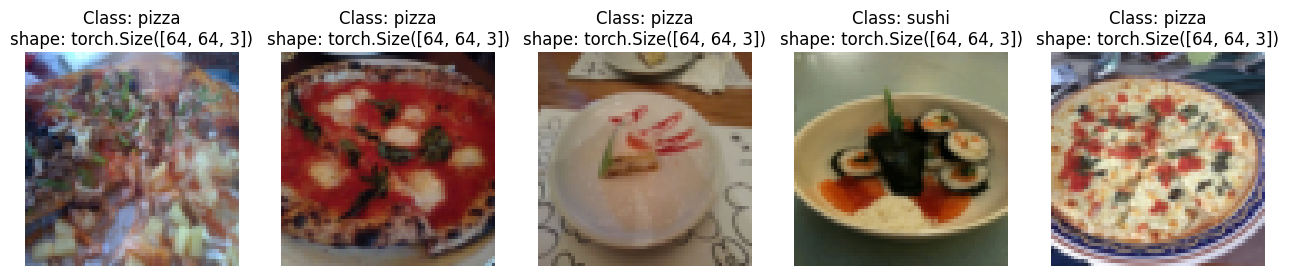

In [43]:
display_random_images(train_data, n=5, classes=train_data_custom.classes, seed=None)

In [44]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x79b163dce710>,
 <torch.utils.data.dataloader.DataLoader at 0x79b163dcf0d0>)

In [45]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various images transformations (filters) to the training data.

Let's take a look at one particular type of data augmentation to train PyTorch vision moodles to state of the art (SOTA) level.

This practice hopefully results in a model that's more generalizable to unseen data.

Resources:
* Blog Post - https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/


In [46]:
# Let's look at trivial augment - https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])


In [47]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg')]

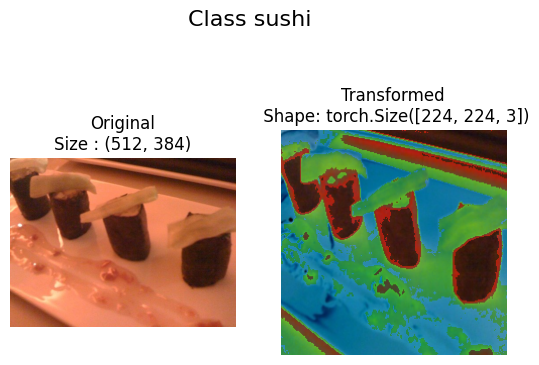

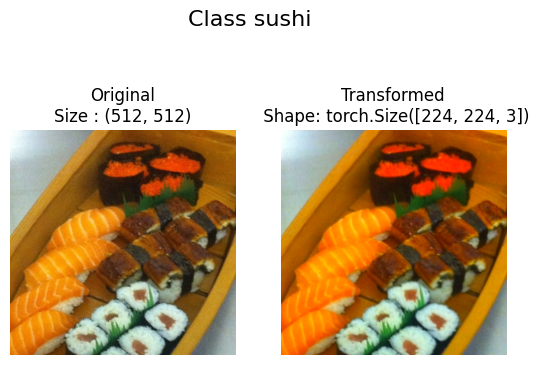

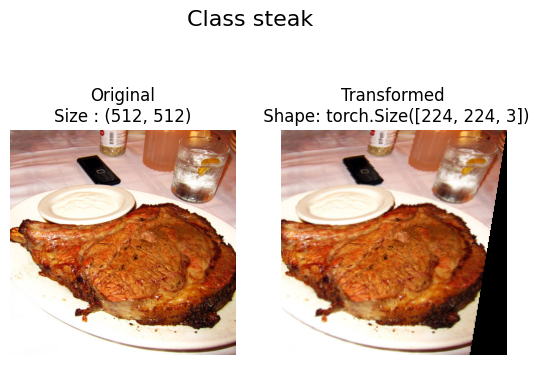

In [48]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

* Tiny VGG - https://poloclub.github.io/cnn-explainer/

Let's replicate the TinyVGG architeture from the previously mentionned cnn-explainer site

### 7.1 Creating transforms and loading data for Model 0

In [49]:
# Creating simple transforms

simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [50]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                                         )
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create the dataloader
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

### 7.2 Create TinyVGG Model class

In [51]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explorer
  """

  def __init__(self,
               input_shape:int,
               hidden_units: int,
               output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=0,
                    stride=1
                    ),
          nn.ReLU(),
          nn.Conv2d(
              in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              padding=0,
              stride=1
          ),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=0,
                    stride=1
                    ),
          nn.ReLU(),
          nn.Conv2d(
              in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              padding=0,
              stride=1
          ),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(
              in_features=hidden_units*13*13,
              out_features=output_shape
          )
      )

  def forward(self, x):
      # x = self. conv_block_1(x)
      # print(x.shape)
      # x = self.conv_block_2(x)
      # print(x.shape)
      # x = self.classifier(x)
      # print(x.shape)

      # return x
      return(self.classifier(self.conv_block_2(self.conv_block_1(x)))) # benefits from operators fusion (Reduce computation time)

In [52]:
torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3, # number of our color channels in our image
    hidden_units=10,
    output_shape=len(train_data_custom.classes)
).to(device)

 ### 7.3 Try a forward pass on a single image(to test the model)

In [53]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [54]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [55]:
10*13*13

1690

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [56]:
# Install torch info
!pip install torchinfo

In [57]:
from torchinfo import summary

In [58]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the models on the dataloader.
*  `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [59]:
# Create the train step functions
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device=device
):

  # Put model in training mode
  model.train()

  # Setup train loss and accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()


    # Calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [60]:
# Create a test step

def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device=device
  ):

  # Put the model in eval mode
  model.eval()

  # Setup test loss and accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through dataloader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      #1. Do the foward pass
      test_pred_logits = model(X)

      #2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      #3. Calculate the acccuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

  # Adjust the metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc



### 7.6 Creating a `train()` function to combine `train_step` and `test_step`

In [61]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader ....
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int=5,
    device=device
):
  # 2. Create an empty result dictionnary
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc" : []
  }

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model=model,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )

    test_loss, test_acc = test_step(
        model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=device
    )

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} ")

    # 5. Update our results dictionnary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the fllled results ad the end of the epochs
  return results

### 7.7 Train and evaluate model 0

In [62]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(
    input_shape=3, # number of color channels of our target images
    hidden_units=10,
    output_shape=len(train_data.classes)
    ).to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup and optimizer
optimizer = torch.optim.Adam(
    params=model_0.parameters(),
    lr=0.001
)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 0

model_0_results = train(
    model=model_0,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS
)

end_time = timer()
print(f"Total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011 
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417 
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924 
Epoch: 3 | Train loss: 1.0846 | Train acc: 0.4023 | Test loss: 1.0606 | Test acc: 0.5729 
Epoch: 4 | Train loss: 1.0664 | Train acc: 0.4180 | Test loss: 1.0660 | Test acc: 0.5644 
Total training time:  8.780 seconds


In [63]:
model_0_results

{'train_loss': [1.1063194125890732,
  1.099798634648323,
  1.086899071931839,
  1.0846090614795685,
  1.066371038556099],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.41796875],
 'test_loss': [1.098320762316386,
  1.06969157854716,
  1.0808487335840862,
  1.060613989830017,
  1.0659819444020588],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5729166666666666,
  0.5643939393939394]}

### 7.8 Plot the loss curve of Model 0

A **loss curve** is a way of tracking your model's progress over time.

A good guide for diffrent loss curves can be - https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic


In [64]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [65]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a result dictionary"""
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary
  acc = results["train_acc"]
  test_acc = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label="train_accuracy")
  plt.plot(epochs, test_acc, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


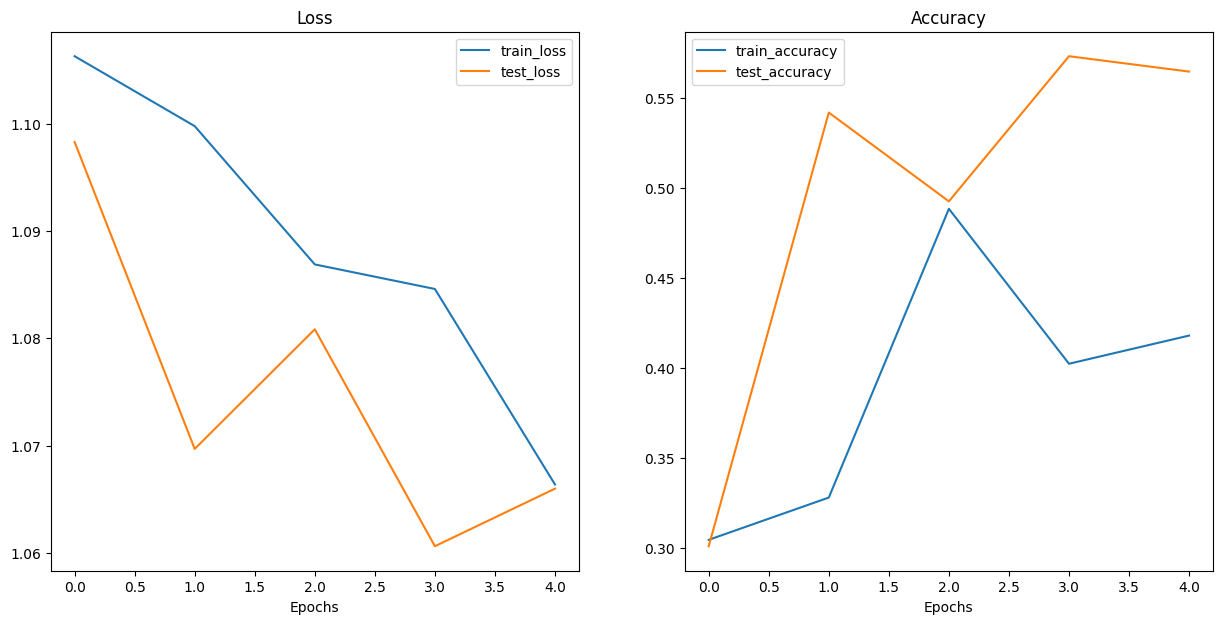

In [66]:
plot_loss_curves(results=model_0_results)

## 8. What should an ideal loss curve look like ?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.


## 9.Model 1: TinyVGG with data augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [67]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [68]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_simple
)

In [69]:
# Turn our datasets into dataloaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)


test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

### 9.3 Construct and train model_1

This time will be using the same model architecture but we have augmented training data.

In [70]:
# Create model_1 and send it to target device
torch.manual_seed(42)

model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderful! Now we have a model a dataloader, lets create a loss function and optimizer and call upon `train()` function developed earlier on.

In [71]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the numbers of epochs
NUM_EPOCHS=5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)


# End the timer
end_time = timer()
print(f"Total training time: {end_time-start_time: 3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test acc: 0.2604 
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1261 | Test acc: 0.2604 
Epoch: 2 | Train loss: 1.0712 | Train acc: 0.4258 | Test loss: 1.1592 | Test acc: 0.2604 
Epoch: 3 | Train loss: 1.1254 | Train acc: 0.3047 | Test loss: 1.1581 | Test acc: 0.2604 
Epoch: 4 | Train loss: 1.0858 | Train acc: 0.4258 | Test loss: 1.1551 | Test acc: 0.3333 
Total training time:  10.847532 seconds


In [72]:
!nvidia-smi

Wed Sep  6 23:39:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |   1171MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 9.4 Plot the loss curve of model 1

A lost curve helps you evalute your models performance overtime

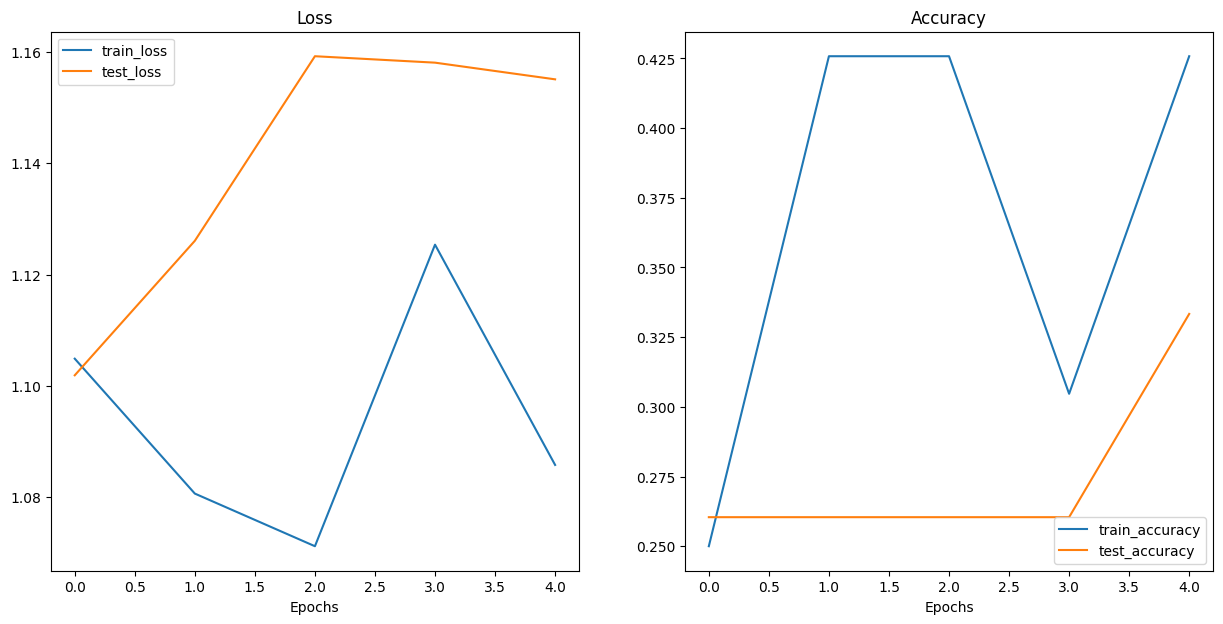

In [73]:
plot_loss_curves(results=model_1_results)

## 10. Compare our models results

After evaluating our modelling experiments on their own, it's important to compare the to each other

There's a few different ways of doing this
1. Hard coding (what where doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights and Biases - https://docs.wandb.ai/quickstart
4. MLFlow - https://mlflow.org/

In [75]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

In [76]:
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099799,0.328125,1.069692,0.541667
2,1.086899,0.488281,1.080849,0.492424
3,1.084609,0.402344,1.060614,0.572917
4,1.066371,0.417969,1.065982,0.564394


In [77]:
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.104914,0.250000,1.101927,0.260417
1,1.080679,0.425781,1.126088,0.260417
2,1.071223,0.425781,1.159248,0.260417
3,1.125394,0.304688,1.158092,0.260417
4,1.085827,0.425781,1.155095,0.333333


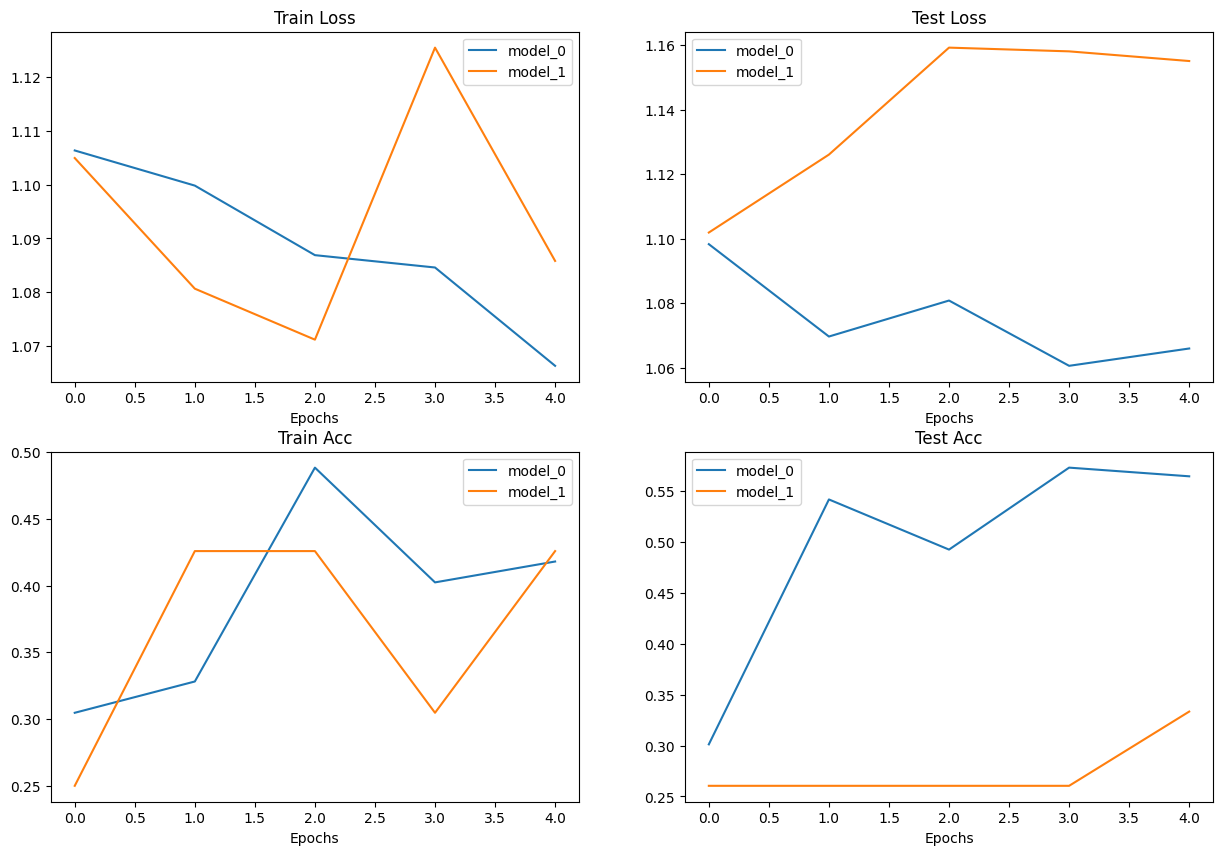

In [78]:
# Plot the results

plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot for the train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="model_0")
plt.plot(epochs, model_1_df["train_loss"], label="model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()


# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="model_0")
plt.plot(epochs, model_1_df["test_loss"], label="model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()


# Plot for the train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="model_0")
plt.plot(epochs, model_1_df["train_acc"], label="model_1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()


# Plot test loss
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="model_0")
plt.plot(epochs, model_1_df["test_acc"], label="model_1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()



## 11. Making a prediction on a custom image

Althrough we've trained a model on custom data... how do you make a prediction on a sample/image that not in the training or testing dataset

In [84]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download image if it does not exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    response = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}....")
    f.write(response.content)
else:
  print(f"{custom_image_path} already exist.Skipping download")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format or model was trained for

* In tensor form float32
* Of the shape 64x64x3
* On the right device


We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [89]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image tensor type: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image tens

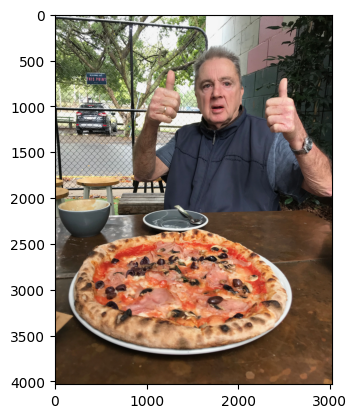

In [88]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

### 11.2 Making a prediction on a custom image with a trained PyTorch Model



In [93]:
# Try to make a predicition on an image on uint8 format

model_1.eval()
with torch.inference_mode():
   model_1(custom_image_uint8.to(device))

RuntimeError: ignored

In [117]:
# Load in the custom image an convert to float32

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

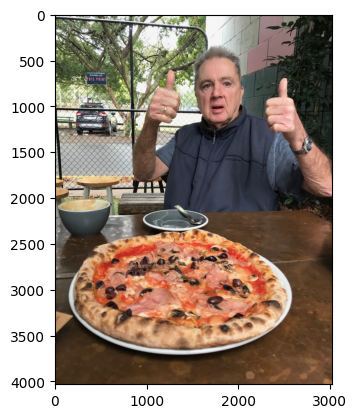

In [99]:
plt.imshow(custom_image.permute(1, 2, 0))

In [118]:
model_1.eval()
with torch.inference_mode():
   model_1(custom_image.to(device))

RuntimeError: ignored

In [119]:
# Create a transform pipeline to resize the image

custom_img_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

In [120]:
custom_img_transformed = custom_img_transform(custom_image)
custom_image.shape, custom_img_transformed.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([3, 4032, 3024]), torch.Size([3, 64, 64]))

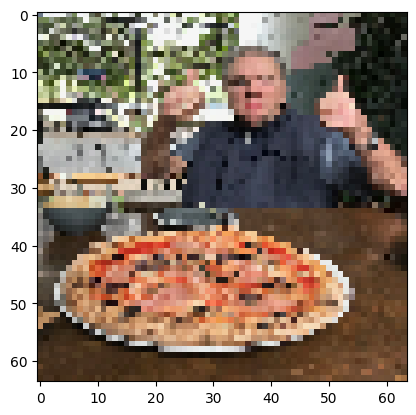

In [121]:
plt.imshow(custom_img_transformed.permute(1, 2, 0))

In [122]:
# This will error: mp batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_img_transformed.to(device))

RuntimeError: ignored

In [111]:
custom_img_transformed.shape

torch.Size([3, 224, 224])

In [112]:
custom_img_transformed.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [123]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_img_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0690,  0.0512, -0.2057]], device='cuda:0')

Note, to make a predicition on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size(1, 3, 64, 64)
* Make sure the image was on the same device as the model

In [127]:
# Convert logits to prediction probabilities

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3647, 0.3583, 0.2771]], device='cuda:0')

In [136]:
# Convert predicition probabilities to prediction labels

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [139]:
class_names = {
    0: "pizza",
    1: "steak",
    2: "sushi"
}
class_names[custom_image_pred_label.item()]

'pizza'

  ### 11.3 Putting custom image prediction together: building a function

  Ideal outcome:
  
  A function where we pass an image path to and have a model to predict on the image + prediciton

In [141]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device=device
):
  """Make a predicition on a target image with a trained model and plots the image predicition."""

  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel value by 255 to get them between [0,1]
  target_image = target_image / 255.

  # Transform our data if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Add and extra dimension to the image (batch dimenssion)
  target_image = target_image.unsqueeze(0)

  # Turn on eval / inference mode
  model.eval()
  with torch.inference_mode():
    # Make a prediction
    target_image_pred = model(target_image.to(device))


  # Convert logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert preds probs to labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the predicition and predicition prob
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dim and rearrange shape to
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.cpu():.3f}"
  plt.title(title)
  plt.axis(False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KeyError: ignored

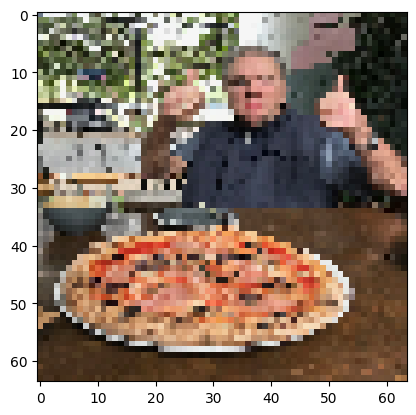

In [143]:
pred_and_plot_image(
    model=model_1,
    image_path=custom_image_path,
    class_names=class_names,
    transform=custom_img_transform,
    device=device
)